# Calculating ground states on large scale systems: Quantum Krylov Subspaces

## Step 1: Map problem to quantum native format

Across disciplines, we're interested in learning ground state properties of quantum systems. Examples include understanding the fundamental nature of particles and forces, predicting and undestanding the behavior of complex materials and understanding bio-chemical interactions and reactions. Because of the exponential growth of the Hilbert space and the correlation that arise in entangled systems, classical algorithm struggle to solve this problem for quantum systems of increasing size. At one end of the spectrum, existing approach that take advantage of the quantum hardware focus on variational quantum methods (e. g. [variational quantum eigen-solver](https://learning.quantum.ibm.com/tutorial/variational-quantum-eigensolver)). These techniques face challenges with current devices because of the high number of function calls required in the optimization process, which is incompatible with advanced error mitigation techniques, thus limiting their efficacy to small systems. At the other end of the spectrum, there are fault-tolerant quantum methods with performance guarantees (e.g. [quantum phase estimation](https://arxiv.org/pdf/quant-ph/0604193.pdf)) which require deep circuits that can be executed only on a fault-tolerant device. For these reasons, we introduce here a quantum algorithm based on subspace methods (as reviewed [here](https://arxiv.org/pdf/2312.00178.pdf)), the quantum Krylov algorithm. This algorithm performs well at large scale on existing quantum hardware, shares similar [performance guarantees](https://arxiv.org/pdf/2110.07492.pdf) as phase estimation, are compatible with advanced error mitigation techniques and could provide results that are classically inaccessible.

Let us now go into more details of how subspace methods, and the quantum Krylov algorithm in particular, work. Given a matrix $H$ for which we want to know its lowest eigenvalue, subspace methods construct of a smaller representation $\tilde{H}$ of $H$, which captures its properties of interest. In the case of the quantum Krylov algorithm, the Krylov subspace is used to construct the effective representation.

### What is the Krylov subspace? 

By definition, the Krylov subspace $K^r$ of order $r$ is the subspace spanned by vectors obtained by multiplying higher powers of $H$, up to $r-1$, with a reference vector $\vert \psi \rangle$.

$$K^r = \left\{ \vert \psi \rangle, H \vert \psi \rangle, H^2 \vert \psi \rangle, ..., H^{r-1} \vert \psi \rangle \right\}$$

We can gain some insight on why this subspace is interesting by expanding the reference state in terms of the eigenvectors $\vert \lambda_i \rangle$ of the matrix $H$:

$$ \vert \psi \rangle = c_1 \vert \lambda_1 \rangle + c_2 \vert \lambda_2 \rangle + ... + c_n \vert \lambda_n \rangle $$

Applying $j^{th}$ power of the matrix $H$ gives:

$$ H^n \vert \psi \rangle = c_1 \lambda_1^n \vert \lambda_1 \rangle + c_2 \lambda_2^n \vert \lambda_2 \rangle + ... + c_n \lambda_n^n \vert \lambda_n \rangle $$

Which means that the component $k$ with the largest eigenvalue $\lambda_k$ is amplified by the power iteration (This can also be a problem as the basis vector become too similar to each other). The same is true for the smallest eigenvalue, if we consider power iteration of the matrix $H^{-1}$.

### Why is it useful for ground state energy problems?

The Krylov subspace is constructed using the power iteration method. Therefore, states in the Krylov subspace corresponding to the multiplication with higher power of the matrix with the reference states will have the contribution of the ground state $\vert \lambda_k \rangle$ enhanced.


The Krylov subspace that we use classically cannot be accessed on a quantum computer as $H$ is not a unitary matrix. Instead, we can use the time-evolution operator $U = e^{-iHt}$ which can be shown to give similar [convergence guarantees](https://arxiv.org/pdf/2110.07492.pdf) as the power method. Powers of $U$ then become different time steps $U^k = e^{-iH(kt)}$.


$$K_U^r = \left\{ \vert \psi \rangle, U \vert \psi \rangle, U^2 \vert \psi \rangle, ..., U^{r-1} \vert \psi \rangle \right\}$$

The subspace $K_U^r$ obtained in this way is called "Unitary" Krylov subspace.


### How does the algorithm work in summary?

First, we want to find a compact represention of the Hamiltonian in the Krylov subspace $\tilde{H}$. Given that the Krylov subspace has dimension $r$, the Hamiltonian projected into the Krylov subspace will have dimensions $r \times r$. We can then easily diagonalize the projected Hamiltonian $\tilde{H}$. However, we cannot directly diagonalize $\tilde{H}$ because of the non-orthogonality of the Krylov subpace vectors. We'll have to measure their overlaps and construct a matrix $\tilde{S}$ collecting them to do so. We can then  solve the generalized eigenvalue problem

$$ \tilde{H} \ \vec{c} = c \ \tilde{S} \ \vec{c} $$

Where $\tilde{H}=\langle \psi_m \vert H \vert \psi_n \rangle$ is the Hamiltonian matrix in the Krylov subspace $K_D = \left\{ \vert \psi_0 \rangle, \vert \psi_1 \rangle, ..., \vert \psi_D \rangle \right\}$ with dimension $D$, $\vec{c}$ is a vector of variational coefficients that are optimized to get the lowest value of the energy $c_{min}=E_{GS}$ and $\tilde{S}=\langle \psi_m  \vert \psi_n \rangle$ is a matrix of overlaps between states of the Krylov subspace.

Each of the Krylov subspace's vectors are obtained by time-evolving the reference state $\vert \psi \rangle$ under the Hamiltonian $H$ for a certain time: $\vert \psi_l \rangle = U \vert \psi \rangle = e^{-i H t_l}\vert \psi \rangle$. 

We can implement the algorithm on a quantum computer by using the Hadamard test to calculate the matrix elements of $\tilde{H}$ and $\tilde{S}$ as expectation values:

$$\langle \psi_m \vert H \vert \psi_n \rangle = $$
$$= \langle \psi \vert  e^{i H t_m}   H e^{-i H t_n} \vert \psi \rangle$$
$$= \langle \psi \vert  e^{i H m \delta t}   H e^{-i H n \delta t} \vert \psi \rangle$$
$$= \langle \psi \vert H e^{-i H (n-m) \delta t} \vert \psi \rangle$$

### Imports and definitions



In [1]:
import numpy as np
import scipy as sp
import matplotlib.pylab as plt
from typing import Union, List
import warnings
warnings.filterwarnings('ignore')

from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.synthesis import SuzukiTrotter
from qiskit.providers.fake_provider import Fake20QV1
from qiskit_ibm_runtime import QiskitRuntimeService, EstimatorV2 as Estimator


def solve_regularized_gen_eig(h: np.ndarray, s:np.ndarray, threshold: float, k: int =1, return_dimn: bool = False) -> Union[float, List[float]]:
    """
    Method for solving the generalized eigenvalue problem with regularization

    Args:
        h (numpy.ndarray):
            The effective representation of the matrix in the Krylov subspace
        s (numpy.ndarray):
            The matrix of overlaps between vectors of the Krylov subspace
        threshold (float):
            Cut-off value for the eigenvalue of s
        k (int):
            Number of eigenvalues to return
        return_dimn (bool):
            Whether to return the size of the regularized subspace

    Returns:
        lowest k-eigenvalue(s) that are the solution of the regularized generalized eigenvalue problem

    
    """
    s_vals, s_vecs = sp.linalg.eigh(s)
    s_vecs = s_vecs.T
    good_vecs = np.array([vec for val, vec in zip(s_vals, s_vecs) if val > threshold])
    h_reg = good_vecs.conj() @ h @ good_vecs.T
    s_reg = good_vecs.conj() @ s @ good_vecs.T
    if k==1:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][0], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][0]
    else:
        if return_dimn:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k], len(good_vecs)
        else:
            return sp.linalg.eigh(h_reg, s_reg)[0][:k]

### Define Hamiltonian

Let's consider the Heisenberg Hamiltonian for $N$ qubits on a linear chain: $H= J \sum_{i,j}^N X_i X_j + Y_i Y_j - Z_i Z_j$

In [2]:
# Define problem Hamiltonian.
n_qubits = 5
J = 1 # coupling strength for ZZ interaction

# Define the Hamiltonian: 
H_int = [['I']*n_qubits for _ in range(3*(n_qubits-1))]
for i in range(n_qubits-1):
    H_int[i][i] = 'Z'
    H_int[i][i+1] = 'Z'
for i in range(n_qubits-1):
    H_int[n_qubits-1+i][i] = 'X'
    H_int[n_qubits-1+i][i+1] = 'X'
for i in range(n_qubits-1):
    H_int[2*(n_qubits-1)+i][i] = 'Y'
    H_int[2*(n_qubits-1)+i][i+1] = 'Y'
H_int = [''.join(term) for term in H_int]
H_tot = [(term, -J) if term.count('Z') == 2 else (term, 1) for term in H_int]

# Get operator
H_op = SparsePauliOp.from_list(H_tot)
print(H_tot)

[('ZZIII', -1), ('IZZII', -1), ('IIZZI', -1), ('IIIZZ', -1), ('XXIII', 1), ('IXXII', 1), ('IIXXI', 1), ('IIIXX', 1), ('YYIII', 1), ('IYYII', 1), ('IIYYI', 1), ('IIIYY', 1)]


Heuristically choose `dt` (based on upper bounds)

In [3]:
from qiskit.quantum_info import Pauli
# Get Hamiltonian restricted to single-particle states
single_particle_H = np.zeros((n_qubits,n_qubits))
for i in range(n_qubits):
    for j in range(i+1):
        for p, coeff in H_op.to_list():
            p_x = Pauli(p).x
            p_z = Pauli(p).z
            if all(p_x[k] == ((i==k)+(j==k))%2 for k in range(n_qubits)):
                sgn = ((-1j)**sum(p_z[k] and p_x[k] for k in range(n_qubits)))*((-1)**p_z[i])
            else:
                sgn = 0
            single_particle_H[i,j] += sgn*coeff
for i in range(n_qubits):
    for j in range(i+1,n_qubits):
        single_particle_H[i,j] = np.conj(single_particle_H[j,i])

# Set dt according to spectral norm
dt = np.pi/np.linalg.norm(single_particle_H, ord=2)
dt

0.7853981633974483

### Set parameters for the algorithm

In [4]:
# Set parameters for quantum Krylov algorithm
krylov_dim = 20 # size of krylov subspace
num_trotter_steps = 4
dt_circ = dt/num_trotter_steps

### Decompose time-evolution operator with Suzuki-Trotter decomposition
Instead of implementing the time-evolution operator exactly we can use the Suzuki-Trotter decomposition to implement an approximation of it. Repeating several times a certain order Trotter decomposition gives us further reduction of the error introduced from the approximation. In the following, we directly build the Trotter implementation in the most efficient way for the interaction graph of the Hamiltonian we are considering (nearest neighbor interactions only). In practice we insert Pauli rotations $R_{xx}$, $R_{yy}$, $R_{zz}$ with a parametrized angle $t$ which correspond to the approximate implementation of $e^{-i (XX + YY + ZZ) t}$. This gives a much shallower circuit than what is obtained using the generic `PauliEvolutionGate()` functionality. 

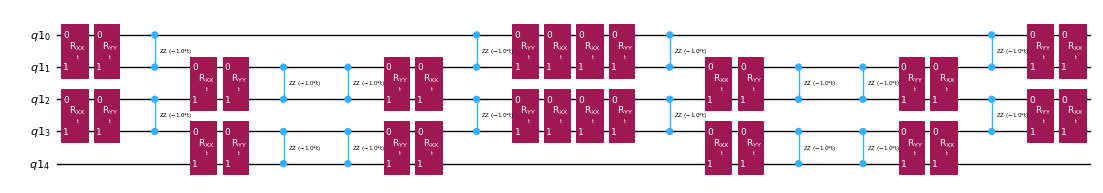

In [5]:
t = Parameter('t')

# Create instruction for rotation about XX+YY-ZZ:
Rxyz_circ = QuantumCircuit(2)
Rxyz_circ.rxx(t,0,1)
Rxyz_circ.ryy(t,0,1)
Rxyz_circ.rzz(-t,0,1)
Rxyz_instr = Rxyz_circ.to_instruction(label='RXX+YY-ZZ')

interaction_list = [[[i, i+1] for i in range(0, n_qubits-1, 2)], [[i, i+1] for i in range(1, n_qubits-1, 2)]] # linear chain

qr = QuantumRegister(n_qubits)
trotter_step_circ = QuantumCircuit(qr)
for i, color in enumerate(interaction_list):
    for interaction in color:
        trotter_step_circ.append(Rxyz_instr, interaction)
reverse_trotter_step_circ = trotter_step_circ.reverse_ops()

qc_evol = QuantumCircuit(qr)
for step in range(num_trotter_steps):
    if step % 2 == 0:
        qc_evol = qc_evol.compose(trotter_step_circ)
    else:
        qc_evol = qc_evol.compose(reverse_trotter_step_circ)

qc_evol.decompose().draw('mpl', fold=-1, scale = 0.5)



### Use an optimized circuit for state preparation

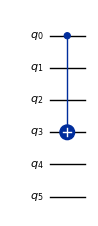

In [6]:
controlled_state_prep = QuantumCircuit(n_qubits + 1)
controlled_state_prep.cx(0,int(n_qubits/2)+1)
controlled_state_prep.draw('mpl', fold=-1, scale=0.5)


controlled_state_prep.draw('mpl', fold=-1, scale=0.5)

### Template circuits for calculating matrix elements of $\tilde{S}$ and $\tilde{H}$ via Hadamard test
The only difference between the circuits used in the Hadamard test will be the phase in the time-evolution operator and the observables measured. Therefore we can prepare a template circuit which represent the generic circuit for the Hadamard test, with placeholders for the gates that depend on the time-evolution operator.

In [7]:
# Parameters for the template circuits
parameters = []
for idx_ket in range(1, krylov_dim):
    parameters.append(dt_circ*(idx_ket))

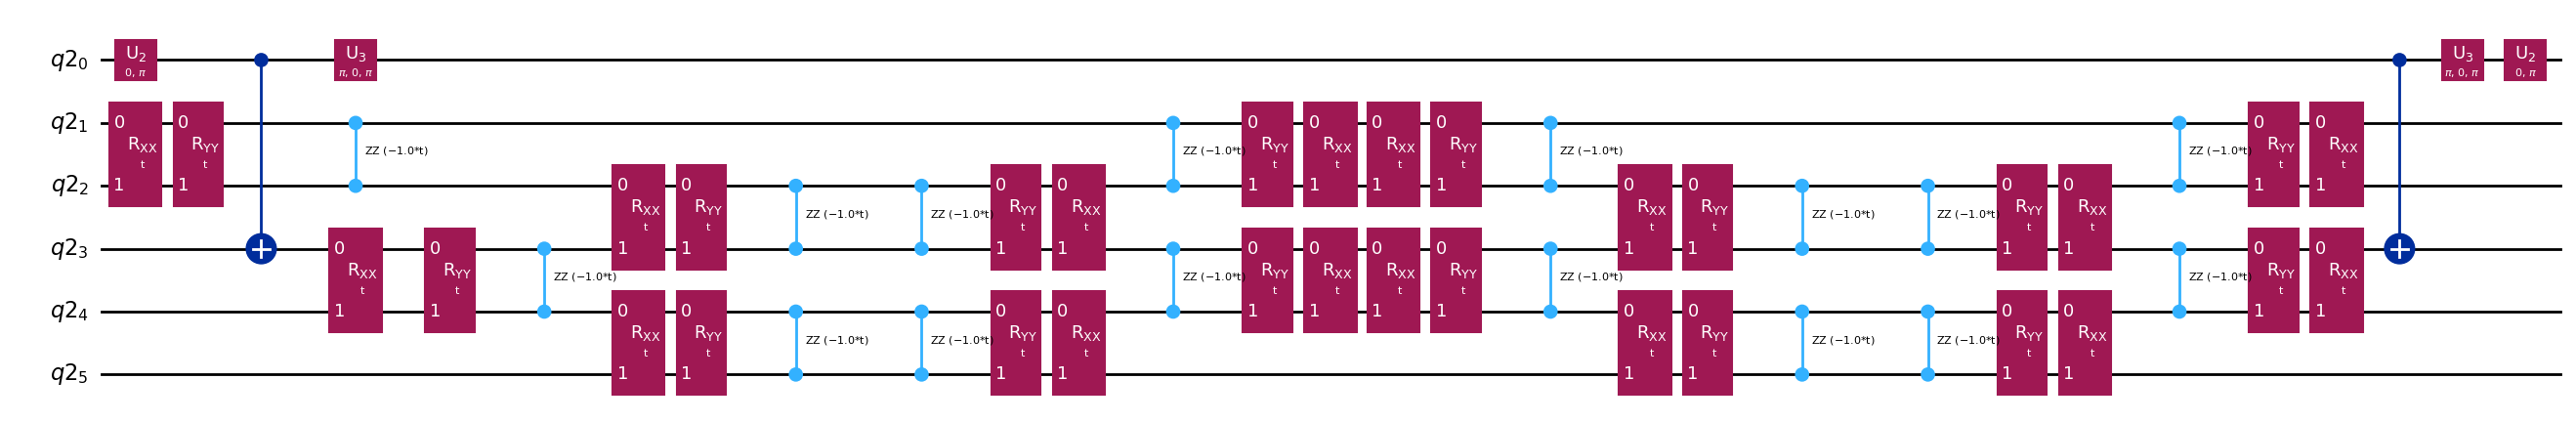

In [8]:
# Create hadamard test circuit for real part
qr = QuantumRegister(n_qubits+1)
qc_real = QuantumCircuit(qr)
qc_real.h(0)
qc_real.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
# qc_real.barrier()
qc_real.compose(qc_evol, list(range(1, n_qubits+1)), inplace=True)
# qc_real.barrier()
qc_real.x(0)
qc_real.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc_real.x(0)
qc_real.h(0)

S_real_circ = qc_real.decompose().copy()

H_real_circ = qc_real.decompose().copy()

# # Create hadamard test circuit for imaginary part
qr = QuantumRegister(n_qubits+1)
qc_imag = QuantumCircuit(qr)
qc_imag.h(0)
qc_imag.sdg(0)
qc_imag.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
# qc_imag.barrier()
qc_imag.compose(qc_evol, list(range(1, n_qubits+1)), inplace=True)
# qc_imag.barrier()
qc_imag.x(0)
qc_imag.compose(controlled_state_prep.inverse(), list(range(n_qubits+1)), inplace=True)
qc_imag.x(0)
qc_imag.h(0)


S_imag_circ = qc_imag.decompose().copy()

H_imag_circ = qc_imag.decompose().copy()

S_real_circ.draw('mpl', fold=-1)

In [ ]:
# circuit_trans_opt = transpile(S_real_circ.decompose().decompose(), Fake20QV1())

# print('The optimized circuit has 2Q gates depth: ', circuit_trans_opt.depth(lambda x: x[0].num_qubits ==2))
# print('Compared to the unoptimized circuit depth of', circuit_trans_unopt.depth(lambda x: x[0].num_qubits == 2))

We have considerably reduced the depth of the Hadamard test with a combination of Trotter approximation and uncontrolled unitaries

## Step 3: Execute using a quantum primitive

Instantiate the backend and set runtime parameters

In [9]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Batch
from qiskit_ibm_runtime.fake_provider import FakeTorino, FakeGuadalupeV2
from qiskit_aer import AerSimulator


SIM = True
NOISE = False
# service = QiskitRuntimeService(instance='ibm-q-internal/technical-enable/utokyol3enableme')#
# service = QiskitRuntimeService(instance='quantum-demonstrations/main/krylov-gs')
service = QiskitRuntimeService(instance='grants/qciss/main')



if SIM:
    # backend = service.least_busy(simulator=True)
    
    if NOISE:
        backend = AerSimulator.from_backend(FakeGuadalupeV2(), seed_simulator=42)

    else:
        backend = AerSimulator()

else:
    backend_id = 'ibm_pinguino1'
    # backend_id = 'ibm_torino'
    backend = service.backend(backend_id)

shots = 300000


In [ ]:
from qiskit_ibm_provider import IBMProvider
from qiskit_aer import AerSimulator
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Batch


SIM = False
NOISE = False

# IBMQ.load_account()
provider = IBMProvider(name="staging")
backend = provider.get_backend('ibm_montecarlo')
shots = 300000


In [ ]:
service = QiskitRuntimeService(name='staging')

backend_id = 'ibm_montecarlo'
backend = service.backend(backend_id)

### Transpile + schedule with DD

In [10]:
from qiskit.circuit.library import XGate, YGate, RZGate
from qiskit.transpiler import InstructionProperties
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)

if not SIM:


    target = backend.target
    basis_gates = list(target.operation_names)


    X = XGate()
    Y = YGate()
    
    # dd_sequence = [X, X, X, X]

    dd_sequence=[XGate(), RZGate(np.pi), XGate(), RZGate(-np.pi)]
    spacing = [1 / 4, 1 / 2, 0, 0, 1 / 4]


    
    y_gate_properties = {}
    for qubit in range(target.num_qubits):
        y_gate_properties.update(
            {
                (qubit,): InstructionProperties(
                    duration=target["x"][(qubit,)].duration,
                    error=target["x"][(qubit,)].error,
                )
            }
        )
    if 'y' not in target.operation_names:
        target.add_instruction(YGate(), y_gate_properties)

    pm = generate_preset_pass_manager(optimization_level=3, backend=backend, basis_gates=basis_gates)


    pm.scheduling = PassManager(
        [
            ALAPScheduleAnalysis(target=target),
            PadDynamicalDecoupling(target=target, dd_sequence=dd_sequence, spacing=spacing),
        ]
    )

    S_real_circ_trans = pm.run(S_real_circ)
    S_imag_circ_trans = pm.run(S_imag_circ)

    H_real_circ_trans = pm.run(H_real_circ)
    H_imag_circ_trans = pm.run(H_imag_circ)

elif SIM and NOISE:
    target = backend.target
    basis_gates = list(target.operation_names)
    pm = generate_preset_pass_manager(optimization_level=3, backend=backend, basis_gates=basis_gates)

    S_real_circ_trans = pm.run(S_real_circ)
    S_imag_circ_trans = pm.run(S_imag_circ)

    H_real_circ_trans = pm.run(H_real_circ)
    H_imag_circ_trans = pm.run(H_imag_circ)


In [ ]:
S_real_circ_trans.draw('mpl', fold=-1, idle_wires=False, scale=0.5)

In [ ]:
S_real_circ_trans.depth(lambda x: x[0].num_qubits==2)

In [ ]:
S_real_circ_trans.count_ops()['cz']

In [ ]:
# S_real_circ.decompose().decompose().draw('mpl', fold=-1, idle_wires=False)

In [ ]:
# S_real_circ.decompose().decompose().depth(lambda x: x[0].num_qubits==True)

In [ ]:
# from qiskit.visualization import timeline_drawer
# from qiskit.transpiler.passes.scheduling import ALAPSchedule
# from qiskit.transpiler import PassManager, InstructionDurations

# b_circ = S_real_circ_trans_dd.assign_parameters({t:1})
# durations = InstructionDurations().from_backend(backend)
# pm = PassManager([ALAPSchedule(durations=durations)])
# sched_circ = pm.run(b_circ)

# timeline_drawer(sched_circ, show_idle=False)
# # timeline_drawer(b_circ)

In [11]:
# Define observables to measure for S
observable = 'I'*(n_qubits) + 'Z'

if not SIM or (SIM and NOISE):

    layout = S_real_circ_trans.layout

    observable_op = SparsePauliOp(observable)
    observable_op = observable_op.apply_layout(layout)
    observable = observable_op.paulis.to_labels()


# Define a set of observables to measure
else:
    observable = ['I'*(n_qubits) + 'Z']

observables_S = [observable]

# Define a sweep over parameter values
params = np.vstack(parameters).T

# Estimate the expectation value for all combinations of
# observables and parameter values, where the pub result will have
# shape (# observables, # parameter values).

if not SIM or (SIM and NOISE):
    pub_S_real = (S_real_circ_trans, observables_S, params)
    pub_S_imag = (S_imag_circ_trans, observables_S, params)
else:
    pub_S_real = (S_real_circ, observables_S, params)
    pub_S_imag = (S_imag_circ, observables_S, params)



# Define observables to measure for H
# Hamiltonian terms to measure
observable_list = []
for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
    # print(pauli)
    observable = pauli[::-1].to_label() + 'Z'
    observable_list.append([observable])


if not SIM or (SIM and NOISE):

    layout = H_real_circ_trans.layout

    observable_trans_list = []
    for observable in observable_list:
        observable_op = SparsePauliOp(observable)
        observable_op = observable_op.apply_layout(layout)
        observable_trans_list.append(observable_op.paulis.to_labels())

    observable_list = observable_trans_list


observables_H = observable_list



if not SIM or (SIM and NOISE):
    pub_H_real = (H_real_circ_trans, observables_H, params)
    pub_H_imag = (H_imag_circ_trans, observables_H, params)
else:
    pub_H_real = (H_real_circ, observables_H, params)
    pub_H_imag = (H_imag_circ, observables_H, params)


In [12]:
# pub_S_real[0].draw('mpl', scale=0.8, fold=-1)

In [13]:
len(pub_S_real[1][0][0])

6

## PEA code

In [ ]:
# Experiment options
max_pubs_per_batch_job = 100
num_randomizations = 7
num_randomizations_learning = 4
shots_per_randomization = 6
learning_pair_depths = [0, 1]
noise_factors = [1, 1.3, 1.6]

# Base option formatting
options = {
    "resilience_level": 2,
    # Builtin resilience settings for ZNE
    # "resilience": {
    #     "measure_mitigation": True,
    #     "zne_mitigation": True,
    #     "zne": {"noise_factors": noise_factors},

    #     # TREX noise learning configuration
    #     "measure_noise_learning": {
    #         "num_randomizations": num_randomizations_learning,
    #         "shots_per_randomization": 3,
    #     },
        
    #     # PEA noise model configuration
    #     "layer_noise_learning": {
    #         "max_layers_to_learn": 5,
    #         "layer_pair_depths": learning_pair_depths,
    #         "shots_per_randomization": shots_per_randomization,
    #         "num_randomizations": num_randomizations_learning,
    #     },
    # },
    
    # # Randomization configuration
    # "twirling": {
    #     "num_randomizations": num_randomizations,
    #     "shots_per_randomization": shots_per_randomization,
    #     "strategy": "active-circuit",
    # },

    # # Experimental settings for PEA method
    # "experimental": {
    #     # Just in case, disable any further qiskit transpilation not related to twirling / DD
    #     "skip_transpilation": False,

    #     # Execution configuration
    #     "execution": {
    #         "max_pubs_per_batch_job": max_pubs_per_batch_job,
    #         "fast_parametric_update": True,
    #     },

    #     # Error Mitigation configuration
    #     "resilience": {
    #         # ZNE Configuration
    #         "zne": {
    #             "amplifier": "pea",
    #             "return_all_extrapolated": True,
    #             "return_unextrapolated": True,
    #             "extrapolated_noise_factors": noise_factors,
    #         }
    #     }
    # }
}

In [ ]:
from qiskit_ibm_runtime import EstimatorV2, Session

session = Session(backend=backend)
estimator = EstimatorV2(session=session, options= options)
job = estimator.run([pub_S_real], precision = 1/np.sqrt(16))
session.close()

In [ ]:
job.job_id

In [ ]:
result = job.result()

In [ ]:
result

In [ ]:
with Session(backend=backend) as session:
    estimator = EstimatorV2(backend=backend,  options={"resilience_level": 2})

    # Sampling options
    estimator.options.seed_estimator = 1
    estimator.options.default_shots = 4
    estimator.options.twirling.num_randomizations = 2
    estimator.options.twirling.shots_per_randomization = 2
    estimator.options.resilience.layer_noise_learning.layer_pair_depths = [0, 4]
    estimator.options.resilience.layer_noise_learning.shots_per_randomization = 2
    estimator.options.resilience.layer_noise_learning.num_randomizations = 2


    # Additional options to enable and modify PEA based ZNE
    # estimator.options.resilience.zne.amplifier = "pea"
    estimator.options.resilience.zne.noise_factors = [1, 1.5, 2]

    # # Experimental options
    estimator.options.experimental.skip_transpilation = True
    estimator.options.experimental.fast_parametric_update = True

    


    job_S_real = estimator.run([pub_S_real])

In [ ]:
job_S_real.result()#.metadata#['circuit_metadata']['physical_qubits']

In [ ]:
from qiskit_ibm_runtime import EstimatorV2    
# from pec_runtime.primitives import EstimatorV2


if SIM and not NOISE:
    with Session(backend=backend) as session:
        estimator = EstimatorV2(session=session)
        job_S_real = estimator.run([pub_S_real], precision=1/np.sqrt(shots))
        job_S_imag = estimator.run([pub_S_imag], precision=1/np.sqrt(shots))
        job_H_real = estimator.run([pub_H_real], precision=1/np.sqrt(shots))
        job_H_imag = estimator.run([pub_H_imag], precision=1/np.sqrt(shots))
elif SIM and NOISE:
    with Session(backend=backend) as session:
        estimator = EstimatorV2(backend=backend,  options={"resilience_level": 2})

        # Sampling options
        estimator.options.seed_estimator = 1
        estimator.options.default_shots = 4
        estimator.options.twirling.num_randomizations = 2
        estimator.options.twirling.shots_per_randomization = 2
        estimator.options.resilience.layer_noise_learning.layer_pair_depths = [0, 4]
        estimator.options.resilience.layer_noise_learning.shots_per_randomization = 2
        estimator.options.resilience.layer_noise_learning.num_randomizations = 2
        estimator.options.execution.fast_parametric_update = True


        # Additional options to enable and modify PEA based ZNE
        # estimator.options.resilience.zne.amplifier = "pea"
        estimator.options.resilience.zne.noise_factors = [1, 1.5, 2]

        # # Experimental options
        estimator.options.experimental.skip_transpilation = True
        estimator.options.experimental.fast_parametric_update = True
        estimator.options.experimental.zne.amplifier = "pea"
        estimator.options.experimental.zne.return_all_extrapolated = True
        estimator.options.experimental.resilience.zne.return_unextrapolated = True
        estimator.options.experimental.resilience.zne.extrapolated_noise_factors = [1, 1.5, 2]
        


        job_S_real = estimator.run([pub_S_real])
        job_S_imag = estimator.run([pub_S_imag])
        job_H_real = estimator.run([pub_H_real])
        job_H_imag = estimator.run([pub_H_imag])

else:
    with Batch(backend=backend) as batch:

        estimator = EstimatorV2(session=batch, backend=backend, options={"resilience_level": 2})
        estimator.options.transpilation.seed_transpiler = 1

        # Sampling options
        estimator.options.seed_estimator = 1
        estimator.options.default_shots = 4
        estimator.options.twirling.num_randomizations = 2
        estimator.options.twirling.shots_per_randomization = 2
        estimator.options.resilience.layer_noise_learning.layer_pair_depths = [0, 4]
        estimator.options.resilience.layer_noise_learning.shots_per_randomization = 2
        estimator.options.resilience.layer_noise_learning.num_randomizations = 2
        estimator.options.execution.fast_parametric_update = True



        # Additional options to enable and modify PEA based ZNE
        # estimator.options.resilience.zne.amplifier = "pea"
        estimator.options.resilience.zne.noise_factors = [1, 1.5, 2]

        # # Experimental options
        # estimator.options.experimental.skip_transpilation = True
        # estimator.options.experimental.execution.fast_parametric_update = True
        # estimator.options.experimental.resilience.zne.amplifier = "pea"
        # estimator.options.experimental.resilience.zne.return_all_extrapolated = True
        # estimator.options.experimental.resilience.zne.return_unextrapolated = True
        # estimator.options.experimental.resilience.zne.extrapolated_noise_factors = [1, 1.5, 2]
        


        job_S_real = estimator.run([pub_S_real])
        job_S_imag = estimator.run([pub_S_imag])
        job_H_real = estimator.run([pub_H_real])
        job_H_imag = estimator.run([pub_H_imag])



## ZNE code

In [ ]:
shots = 100000

In [ ]:
from qiskit_aer.primitives import EstimatorV2 as Estimator
from qiskit_aer.noise import NoiseModel

noise_model = NoiseModel().from_backend(FakeGuadalupeV2())

if SIM and NOISE:
        estimator = Estimator()
        estimator.options.backend_options = {'noise_model': noise_model}
        estimator.options.resilience_level = 2
        
        job_S_real = estimator.run([pub_S_real], precision=1/np.sqrt(shots))
        job_S_imag = estimator.run([pub_S_imag], precision=1/np.sqrt(shots))
        job_H_real = estimator.run([pub_H_real], precision=1/np.sqrt(shots))
        job_H_imag = estimator.run([pub_H_imag], precision=1/np.sqrt(shots))

# else:
#     with Batch(backend=backend) as batch:

#         estimator = Estimator(session=batch, options={"resilience_level": 1, "experimental": {"execution": {"fast_parametric_update" : True}}})

#         job_S_real = estimator.run([pub_S_real], precision=1/np.sqrt(shots))
#         job_S_imag = estimator.run([pub_S_imag], precision=1/np.sqrt(shots))
#         job_H_real = estimator.run([pub_H_real], precision=1/np.sqrt(shots))
#         job_H_imag = estimator.run([pub_H_imag], precision=1/np.sqrt(shots))

In [ ]:
estimator.options

In [ ]:
job_S_real.metadata


## Without PEA

Circuits for $t=0$ are classically calculable

In [14]:
from qiskit.quantum_info import StabilizerState, Pauli



H_real_circ_cliff = H_real_circ.assign_parameters({t:0})
H_imag_circ_cliff = H_imag_circ.assign_parameters({t:0})
S_real_circ_cliff = S_real_circ.assign_parameters({t:0})
S_imag_circ_cliff = S_imag_circ.assign_parameters({t:0})

observables_S_cliff = 'I'*(n_qubits) + 'Z'

observables_H_cliff = []
for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
    # print(pauli)
    observable = pauli[::-1].to_label() + 'Z'
    observables_H_cliff.append(observable)



# Get expectation values from experiment
S_expval_real = StabilizerState(S_real_circ_cliff).expectation_value(Pauli('I'*(n_qubits) + 'Z'))
S_expval_imag = StabilizerState(S_imag_circ_cliff).expectation_value(Pauli('I'*(n_qubits) + 'Z'))

# Get expectation values
S_expval = S_expval_real + 1j*S_expval_imag

H_expval = 0
for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
    # Get expectation values from experiment
    expval_real = StabilizerState(H_real_circ_cliff).expectation_value(Pauli(observables_H_cliff[obs_idx]))
    expval_imag = StabilizerState(H_imag_circ_cliff).expectation_value(Pauli(observables_H_cliff[obs_idx]))
    expval = expval_real + 1j*expval_imag


    # Fill-in matrix elements
    H_expval += coeff*expval


H_expval

0j

Execute circuits for $\tilde{S}$ and $\tilde{H}$ with the Estimator

In [15]:
if SIM:
    with Session(backend=backend) as session:
        estimator = Estimator(session=session)
        job_S_real = estimator.run([pub_S_real], precision=1/np.sqrt(shots))
        job_S_imag = estimator.run([pub_S_imag], precision=1/np.sqrt(shots))
        job_H_real = estimator.run([pub_H_real], precision=1/np.sqrt(shots))
        job_H_imag = estimator.run([pub_H_imag], precision=1/np.sqrt(shots))

else:
    with Batch(backend=backend) as batch:

        estimator = Estimator(session=batch, options={"resilience_level": 1, "experimental": {"execution": {"fast_parametric_update" : False}}})

        # estimator.options.resilience.zne_mitigation=True
        # estimator.options.resilience.zne.extrapolator='linear'
        # estimator.options.resilience.zne.noise_factors = [1,1.3,1.6]

        job_S_real = estimator.run([pub_S_real], precision=1/np.sqrt(shots))
        job_S_imag = estimator.run([pub_S_imag], precision=1/np.sqrt(shots))
        job_H_real = estimator.run([pub_H_real], precision=1/np.sqrt(shots))
        job_H_imag = estimator.run([pub_H_imag], precision=1/np.sqrt(shots))


In [16]:
job_S_real_id = job_S_real.job_id()
job_S_imag_id = job_S_imag.job_id()
job_H_real_id = job_H_real.job_id()
job_H_imag_id = job_H_imag.job_id()
print(job_S_real_id)
print(job_S_imag_id)
print(job_H_real_id)
print(job_H_imag_id)


260de0a3-4794-4f67-b341-f0c44f8c4446
ac129fa6-3a34-45fd-bf8f-23d364aac72b
f8187927-8593-460f-85da-6046075bd906
772a0424-31ff-4a48-9374-db4f560acb63


## Step 4: Post-process and analyze results

In [18]:
S_real_results = job_S_real.result()[0]
S_imag_results = job_S_imag.result()[0]
H_real_results = job_H_real.result()[0]
H_imag_results = job_H_imag.result()[0]

In [19]:
prefactors = []
E0t_array = []
for i, circ in enumerate(iter(qc_evol.assign_parameters([(i*dt)/num_trotter_steps]) for i in range(1, krylov_dim))):
    phase = 1.0
    E0t = 0
    for instruction in circ.data:
        if instruction.operation.name != 'swap' and instruction.operation.name != 'barrier':
            # All the non-swap gates are XX+YY+ZZ rotations, which add a phase to the all-zeros state.
            if instruction.operation.params:
                E0t += float(instruction.operation.params[0])
                # phase *= np.exp(1j*float(instruction.operation.params[0])/2)
                phase *= np.exp(-1j*float(instruction.operation.params[0])/2) # NY added, we need to `subtract` the E0 * t so minus sign
            # assert(float(instruction.operation.params[0]._symbol_expr) == i*dt/n_T_step)
    prefactors.append(phase)

Once we have the results of the circuit executions we can post-process the data to calculate the matrix elements of $\tilde{S}$

In [20]:
import itertools
# Assemble S, the overlap matrix of dimension D:
S_first_row = np.zeros(krylov_dim, dtype=complex)
S_first_row[0] = 1+0j

# Add in ancilla-only measurements:
for i in range(krylov_dim-1):

    # Get expectation values from experiment
    expval_real = S_real_results.data.evs[0][i]
    expval_imag = S_imag_results.data.evs[0][i]

    # Get expectation values
    expval = expval_real + 1j*expval_imag
    # Get the coefficients and expectation values corresponding to actual terms in the Hamiltonian (as opposed to the ancilla-only measurements).
    S_first_row[i+1] += prefactors[i]*expval

S_first_row_list =  S_first_row.tolist() #for saving purposes     
            
            
S_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        S_circ[j,i] = S_first_row[i-j]
    else:
        S_circ[j,i] = np.conj(S_first_row[j-i])

In [21]:
from sympy import Matrix
Matrix(S_circ)

Matrix([
[                                       1.0, -0.477673333333334 - 0.00438000000000005*I,            -0.25164 + 0.0503866666666666*I,    0.227286666666666 - 0.243466666666666*I,             -0.0015399999999998 + 0.5005*I,    0.225446666666667 - 0.542486666666667*I,              -0.248633333333333 + 0.3027*I,  -0.480446666666667 - 0.0572200000000002*I,                1.0 - 0.00189333333333206*I,  -0.475406666666667 + 0.0534933333333323*I,             -0.247546666666667 - 0.30316*I,    0.227546666666665 + 0.546793333333334*I, 0.000873333333333945 - 0.500793333333334*I,                          0.2278 + 0.2435*I,            -0.24872 - 0.0492600000000001*I, -0.476759999999999 + 0.00471999999999859*I,                1.0 - 0.00365999999999902*I, -0.477760000000001 - 0.00103333333333287*I,            -0.25362 + 0.0517399999999997*I,    0.227706666666667 - 0.243793333333333*I],
[-0.477673333333334 + 0.00438000000000005*I,                                        1.0, -0.477673333333334 -

And the matrix elements of $\tilde{H}$

In [22]:
import itertools
# Assemble S, the overlap matrix of dimension D:
H_first_row = np.zeros(krylov_dim, dtype=complex)
H_first_row[0] = H_expval

for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
    # Add in ancilla-only measurements:
    for i in range(krylov_dim-1):

        # Get expectation values from experiment
        expval_real = H_real_results.data.evs[obs_idx][i]
        expval_imag = H_imag_results.data.evs[obs_idx][i]

        # Get expectation values
        expval = expval_real + 1j*expval_imag
        # Get the coefficients and expectation values corresponding to actual terms in the Hamiltonian (as opposed to the ancilla-only measurements).
        H_first_row[i+1] += prefactors[i]*coeff*expval
        
H_first_row_list = H_first_row.tolist()           
            
H_eff_circ = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        H_eff_circ[j,i] = H_first_row[i-j]
    else:
        H_eff_circ[j,i] = np.conj(H_first_row[j-i])





In [23]:
from sympy import Matrix
Matrix(H_eff_circ)

Matrix([
[                                          0,     0.0500999999999998 + 2.25077333333333*I,     -0.504933333333333 - 1.20433333333333*I,      1.45963333333333 - 0.622086666666666*I,  -1.99913333333333 - 0.000453333333332531*I,       1.45531333333333 + 1.16198666666667*I,    -0.502806666666666 - 0.206233333333333*I,    0.0497066666666672 - 0.948806666666667*I, 0.00812666666666667 - 0.00183999999999999*I,    0.0382333333333312 + 0.956893333333334*I,    -0.509086666666667 + 0.201786666666666*I,       1.45353333333334 - 1.16558666666666*I,   -2.00026666666667 - 0.00270000000000244*I,                1.4576 + 0.628373333333333*I,               -0.497886666666667 + 1.2063*I,     0.0471600000000066 - 2.26101333333333*I,             0.00259333333333334 - 0.00216*I,     0.0361266666666688 + 2.26101333333334*I,     -0.499266666666665 - 1.21808666666667*I,      1.45291333333334 - 0.625526666666663*I],
[    0.0500999999999998 - 2.25077333333333*I,                                           0

Finally, we can solve the generalized eigenvalue problem for $\tilde{H}$:

$$\tilde{H} \vec{c} = c \tilde{S} \vec{c}$$

and get an estimate of the ground state energy $c_{min}$

In [31]:
gnd_en_circ_est_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ[:d, :d], S_circ[:d, :d], threshold=5e-1)
    gnd_en_circ_est_list.append(gnd_en_circ_est)
    print('The estimated ground state energy is: ', gnd_en_circ_est)

The estimated ground state energy is:  0.0
The estimated ground state energy is:  -2.5192150457581066
The estimated ground state energy is:  -2.1306785912615154
The estimated ground state energy is:  -3.4144206113331084
The estimated ground state energy is:  -4.30575812503112
The estimated ground state energy is:  -4.23357363980573
The estimated ground state energy is:  -4.448065722052275
The estimated ground state energy is:  -4.550084296374525
The estimated ground state energy is:  -5.785164025190577
The estimated ground state energy is:  -4.811689590223933
The estimated ground state energy is:  -4.022134943095522
The estimated ground state energy is:  -3.8285308684794743
The estimated ground state energy is:  -4.17146973821021
The estimated ground state energy is:  -4.753900596932567
The estimated ground state energy is:  -6.0316996580945155
The estimated ground state energy is:  -6.001579935845579
The estimated ground state energy is:  -6.009103825807484
The estimated ground state 

In [32]:
# gnd_en_circ_est_list_1 = []
# for d in range(1, krylov_dim+1):
#     # Solve generalized eigenvalue problem
#     gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ_1[:d, :d], S_circ_1[:d, :d], threshold=1e-1)
#     gnd_en_circ_est_list_1.append(gnd_en_circ_est)
#     print('The estimated ground state energy is: ', gnd_en_circ_est)

In [33]:
# gnd_en_circ_est_list_0 = []
# for d in range(1, krylov_dim+1):
#     # Solve generalized eigenvalue problem
#     gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ_0[:d, :d], S_circ_0[:d, :d], threshold=1e-1)
#     gnd_en_circ_est_list_0.append(gnd_en_circ_est)
#     print('The estimated ground state energy is: ', gnd_en_circ_est)

In [34]:
# gnd_en_circ_est_list_2 = []
# for d in range(1, krylov_dim+1):
#     # Solve generalized eigenvalue problem
#     gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ_2[:d, :d], S_circ_2[:d, :d], threshold=1e-2)
#     gnd_en_circ_est_list_2.append(gnd_en_circ_est)
#     print('The estimated ground state energy is: ', gnd_en_circ_est)

In [35]:
from qiskit.quantum_info import Pauli
import time
import itertools as it

H_x = []
for p, coeff in H_op.to_list():
    H_x.append(set([i for i,v in enumerate(Pauli(p).x) if v]))

H_z = []
for p, coeff in H_op.to_list():
    H_z.append(set([i for i,v in enumerate(Pauli(p).z) if v]))

H_c = H_op.coeffs

print('n_sys_qubits', n_qubits)

# n_exc particle Hamiltonian:

n_exc = 1
sub_dimn = int(sp.special.comb(n_qubits+1,n_exc))
print('n_exc', n_exc, ', subspace dimension', sub_dimn)

few_particle_H = np.zeros((sub_dimn,sub_dimn), dtype=complex)

sparse_vecs = [set(vec) for vec in it.combinations(range(n_qubits+1),r=n_exc)] # list all of the possible sets of n_exc indices of 1s in n_exc-particle states

start_time = time.time()
m = 0
for i, i_set in enumerate(sparse_vecs):
    for j, j_set in enumerate(sparse_vecs):
        m += 1
        # if m % int((sub_dimn**2)/100) == 0:
        #     print(np.round(m/int((sub_dimn**2)/100),2), '% complete, time =', time.time()-start_time)
        #     start_time = time.time()

        if len(i_set.symmetric_difference(j_set)) <= 2:

            for p_x, p_z, coeff in zip(H_x, H_z, H_c):

                if i_set.symmetric_difference(j_set) == p_x:
                    sgn = ((-1j)**len(p_x.intersection(p_z)))*((-1)**len(i_set.intersection(p_z)))
                else:
                    sgn = 0

                few_particle_H[i,j] += sgn*coeff

gs_en = min(np.linalg.eigvalsh(few_particle_H))
print('gs_en', gs_en)




n_sys_qubits 5
n_exc 1 , subspace dimension 6
gs_en -4.000000000000001


In [36]:
gs_en = min(sp.sparse.linalg.eigsh(H_op.to_matrix(), which = "SA", k = 10)[0])
print('gs_en', gs_en)


gs_en -4.000000000000006


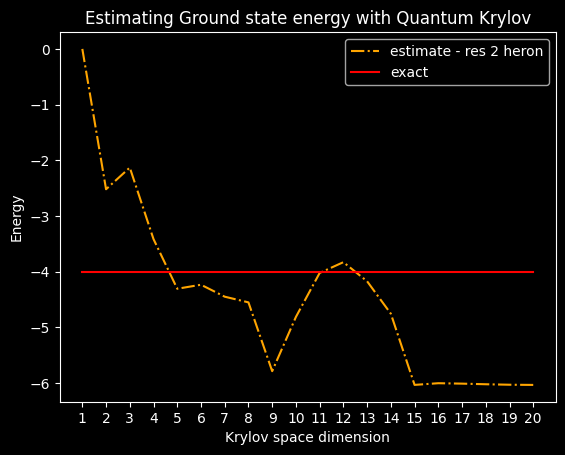

In [37]:
# plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list_0, color = 'blue', linestyle='-.' , label = 'estimate - res 0 ')
# plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list_1, color = 'yellow', linestyle='-.' , label = 'estimate - res 1 ')
# plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list_2, color = 'green', linestyle='-.' , label = 'estimate - res 2')
plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list, color = 'orange', linestyle='-.' , label = 'estimate - res 2 heron')
plt.plot(range(1, krylov_dim+1), [gs_en]*krylov_dim, color = 'red', linestyle='-' , label = 'exact')
plt.xticks(range(1, krylov_dim+1), range(1, krylov_dim+1))
plt.legend()
plt.xlabel('Krylov space dimension')
plt.ylabel('Energy')
plt.title('Estimating Ground state energy with Quantum Krylov')
plt.show()

### Check Paulis

#### Theory calculation (phase issue with real expvals)

In [ ]:
# THIS FUNCTION CALCULATES THE PAULI MATRICES FOR EACH DIMENSION IN d_list, USING NOBU'S k-PARTICLE CODE
# Note that passing in vectors_kp is optional but if you already have it from the Krylov matrix calculation, it can save time.
from utils_k_particle import compute_pauli_matrices
from utils_k_particle import get_indexes_for_m_particles, k_particle_excitation, simulate_unitary_kparticle_from_interaction_list

fixed_control = 0
excitations = [int(n_qubits/2)+1]
H = H_op     

k = len(excitations)
indices = get_indexes_for_m_particles(n_qubits, k)

initial_state_kp = k_particle_excitation(n_qubits, excitations, indices)
vectors_kp = [simulate_unitary_kparticle_from_interaction_list(interaction_list, initial_state_kp, n_qubits, k, num_trotter_steps, param = (i*dt)/num_trotter_steps, as_sparse = True) for i in range(krylov_dim)]

all_exp_vals, vectors_kp = compute_pauli_matrices(n_qubits, fixed_control, excitations, H, interaction_list, num_trotter_steps, dt, list(range(krylov_dim)), vectors_kp)



H_first_row_exact = np.zeros(krylov_dim, dtype=complex)
prefactors_exact = [1+0j] + prefactors
for i, expvals_dict in enumerate(all_exp_vals):


    res_dict_sim = {}
    for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
        # Get expectation values from experiment
        obs = observables_H_cliff[obs_idx]
        new_obs = obs[:-1]
        expval_real = expvals_dict[new_obs + 'X']
        expval_imag = expvals_dict[new_obs + 'Y']


        expval = expval_real + 1j*expval_imag

        H_first_row_exact[i] += prefactors_exact[i]*coeff*expval



H_first_row_exact_list = H_first_row_exact.tolist()           
            
H_eff_circ_exact = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        H_eff_circ_exact[j,i] = H_first_row_exact[i-j]
    else:
        H_eff_circ_exact[j,i] = np.conj(H_first_row_exact[j-i])

In [ ]:
Matrix(H_eff_circ_exact)

#### Numerical calculation (few qubits only!)

In [ ]:
from qiskit.quantum_info import Statevector, Pauli

H_first_row_sim = np.zeros(krylov_dim, dtype=complex)
H_first_row_sim[0] = H_expval

S_first_row_sim = np.zeros(krylov_dim, dtype=complex)
S_first_row_sim[0] = 1+0j

all_exp_vals_sim = []
for i, param in enumerate(parameters):

    H_real_circ_cliff = H_real_circ.assign_parameters({t:param})
    H_imag_circ_cliff = H_imag_circ.assign_parameters({t:param})
    S_real_circ_cliff = S_real_circ.assign_parameters({t:param})
    S_imag_circ_cliff = S_imag_circ.assign_parameters({t:param})

    observables_S_cliff = 'I'*(n_qubits) + 'Z'

    observables_H_cliff = []
    for pauli, coeff in zip(H_op.paulis, H_op.coeffs):
        # print(pauli)
        observable = pauli[::-1].to_label() + 'Z'
        observables_H_cliff.append(observable)



    # Get expectation values from experiment
    S_expval_real = Statevector(S_real_circ_cliff).expectation_value(Pauli('I'*(n_qubits) + 'Z'))
    S_expval_imag = Statevector(S_imag_circ_cliff).expectation_value(Pauli('I'*(n_qubits) + 'Z'))

    # Get expectation values
    S_expval = S_expval_real + 1j*S_expval_imag

    S_first_row_sim[i+1] += prefactors[i]*S_expval


    res_dict_sim = {}
    for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
        # Get expectation values from experiment
        expval_real = Statevector(H_real_circ_cliff).expectation_value(Pauli(observables_H_cliff[obs_idx]))
        expval_imag = Statevector(H_imag_circ_cliff).expectation_value(Pauli(observables_H_cliff[obs_idx]))
        obs = observables_H_cliff[obs_idx]
        new_obs = obs[:-1]
        res_dict_sim[new_obs + 'X'] = expval_real
        res_dict_sim[new_obs + 'Y'] = expval_imag


        expval = expval_real + 1j*expval_imag


        H_first_row_sim[i+1] += prefactors[i]*coeff*expval

    all_exp_vals_sim.append(res_dict_sim)


H_first_row_sim_list = H_first_row_sim.tolist()           
            
H_eff_circ_sim = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        H_eff_circ_sim[j,i] = H_first_row_sim[i-j]
    else:
        H_eff_circ_sim[j,i] = np.conj(H_first_row_sim[j-i])

            
            
S_circ_sim = np.zeros((krylov_dim, krylov_dim), dtype=complex)

# Distribute entries from first row across matrix:
for i,j in itertools.product(range(krylov_dim),repeat=2):
    if i >= j:
        S_circ_sim[j,i] = S_first_row_sim[i-j]
    else:
        S_circ_sim[j,i] = np.conj(S_first_row_sim[j-i])


In [ ]:
gnd_en_circ_sim_est_list = []
for d in range(1, krylov_dim+1):
    # Solve generalized eigenvalue problem
    gnd_en_circ_est = solve_regularized_gen_eig(H_eff_circ_sim[:d, :d], S_circ_sim[:d, :d], threshold=4e-2)
    gnd_en_circ_sim_est_list.append(gnd_en_circ_est)
    print('The estimated ground state energy is: ', gnd_en_circ_est)

In [ ]:
plt.plot(range(1, krylov_dim+1), gnd_en_circ_est_list, color = 'orange', linestyle='-.' , label = 'estimate - res 1 heron')
plt.plot(range(1, krylov_dim+1), gnd_en_circ_sim_est_list, color = 'blue', linestyle='-.' , label = 'estimate - sim')
plt.plot(range(1, krylov_dim+1), [gs_en]*krylov_dim, color = 'red', linestyle='-' , label = 'exact')
plt.xticks(range(1, krylov_dim+1), range(1, krylov_dim+1))
plt.legend()
plt.xlabel('Krylov space dimension')
plt.ylabel('Energy')
plt.title('Estimating Ground state energy with Quantum Krylov')
plt.show()

#### Experimental values

In [ ]:
all_exp_vals_exp = []
for idx in range(krylov_dim-1):
    res_dict = {}
    for obs_idx, (pauli, coeff) in enumerate(zip(H_op.paulis, H_op.coeffs)):
        # Get expectation values from experiment
        expval_real = H_real_results.data.evs[obs_idx][idx]
        expval_imag = H_imag_results.data.evs[obs_idx][idx]
        obs = observables_H_cliff[obs_idx]
        new_obs = obs[:-1]
        res_dict[new_obs + 'X'] = expval_real
        res_dict[new_obs + 'Y'] = expval_imag
    all_exp_vals_exp.append(res_dict)



#### Compare

In [ ]:
idx  = 6
for pauli, val in all_exp_vals_exp[idx].items():
    
    # if pauli[-1] == 'X' and abs(np.round(phase_factor.real, 2)) > 0:
    #     all_exp_vals[idx+1][pauli] = phase_factor.real*all_exp_vals[idx+1][pauli]
    # if pauli[-1] == 'Y' and abs(np.round(phase_factor.imag, 2)) > 0:
    #     all_exp_vals[idx+1][pauli] = phase_factor.imag*all_exp_vals[idx+1][pauli]


    print(pauli, np.round(val, 3), np.round(all_exp_vals_sim[idx][pauli],3), np.round(all_exp_vals[idx+1][pauli], 3))

In [ ]:
idx  = 0
for pauli, val in all_exp_vals_exp[idx].items():
    if abs(val) > 0.1:
        damp_sim = abs(val/all_exp_vals_sim[idx][pauli])
        damp_ex = abs(val/all_exp_vals[idx+1][pauli])
        print(pauli, np.round(damp_sim, 3), np.round(damp_ex,3))

### Save data

In [ ]:
import os
import pickle
import time

time_string = time.strftime("%m%d%Y_%H%M%S")
data_dir_path = f'data/{backend_id}_{n_qubits}q_{time_string}/'
# Save experiment parameters
var_dict = {k: globals()[k] for k in [ 'n_qubits',
                                        'J',
                                        'H_tot',
                                        'dt',
                                        'krylov_dim',
                                        'num_trotter_steps',
                                        'dt_circ',
                                        'parameters',
                                        'backend_id',
                                        'shots',
                                        'observables_S',
                                        'observables_H',
                                        'pub_S_real',
                                        'pub_S_imag',
                                        'pub_H_real',
                                        'pub_H_imag',
                                        'job_S_real_id',
                                        'job_S_imag_id',
                                        'job_H_real_id',
                                        'job_H_imag_id',
                                        'S_expval',
                                        'H_expval',
                                        'prefactors',
                                        'S_first_row_list',
                                        'H_first_row_list',
                                        'n_exc',
                                        'gs_en',]}



# Save to Box folder (avoid Github large file storage issues)
os.makedirs(os.path.dirname(data_dir_path), exist_ok=True)
fname = data_dir_path + "experiment_parameters.pickle"
with open(fname, "wb") as f:
    pickle.dump(var_dict, f)


np.save(data_dir_path + 'S_real_results_evs', S_real_results.data.evs)
np.save(data_dir_path + 'S_imag_results_evs', S_imag_results.data.evs)
np.save(data_dir_path + 'H_real_results_evs', H_real_results.data.evs)
np.save(data_dir_path + 'H_imag_results_evs', H_imag_results.data.evs)

np.save(data_dir_path + 'S_real_results_metadata', S_real_results.metadata)
np.save(data_dir_path + 'S_imag_results_metadata', S_imag_results.metadata)
np.save(data_dir_path + 'H_real_results_metadata', H_real_results.metadata)
np.save(data_dir_path + 'H_imag_results_metadata', H_imag_results.metadata)